# <b>Training A Face Emotion Detector<b/>

In [1]:
# importing libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers,applications
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D 

In [2]:
#getting all the directories

train_dir= r"D:\ALMABETTER\CAPSTONE 5 - FACIAL RECOGNITION SOFTWARE\train"

val_dir= r"D:\ALMABETTER\CAPSTONE 5 - FACIAL RECOGNITION SOFTWARE\validation"

test_dir= r"D:\ALMABETTER\CAPSTONE 5 - FACIAL RECOGNITION SOFTWARE\test"

# **EDA**

First we'll do an image count for validation and train dataset.

In [3]:
# lsit of all emotions
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
#coounting all the emotions in train and validation set
def count_exp(path, set_):
    dict_ = {}
    for expression in emotions:
        dir_ = os.path.join(path, expression)
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(val_dir, 'test')


In [5]:
#count for train data set
train_count

,angry,disgust,fear,happy,neutral,sad,surprise
train,4545,1042,4260,7201,4965,5344,3171


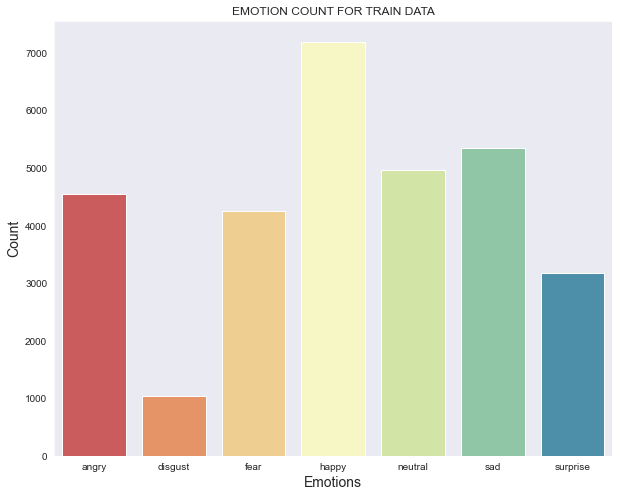

In [6]:
#plotting emotion count for train data
sns.set_style("dark")
plt.figure(figsize= (10,8))
sns.barplot(data=train_count, palette = 'Spectral')
plt.xlabel("Emotions", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("EMOTION COUNT FOR TRAIN DATA")
plt.show()

In [7]:
#count for validation data set
test_count

,angry,disgust,fear,happy,neutral,sad,surprise
test,958,166,1024,1772,1233,1248,831


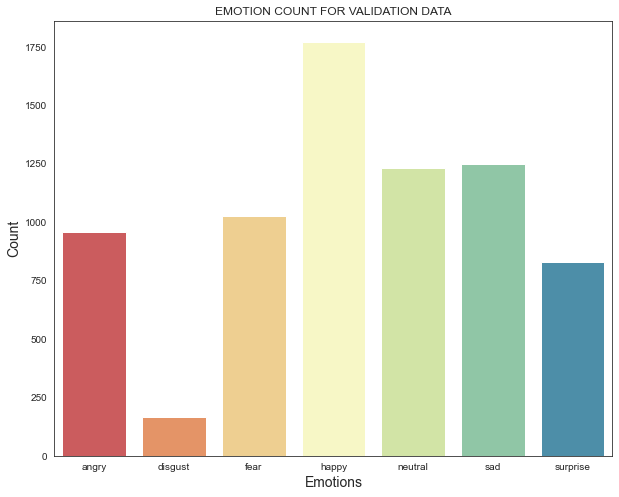

In [787]:
#plotting emotion count for validation data
plt.figure(figsize= (10,8))
sns.barplot(data=test_count, palette = 'Spectral')
plt.xlabel("Emotions", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("EMOTION COUNT FOR VALIDATION DATA")
plt.show()

Let's take a look at some of the images for each emotion

In [795]:
#function to plot images for all emotions

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

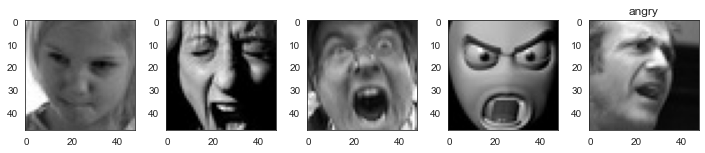

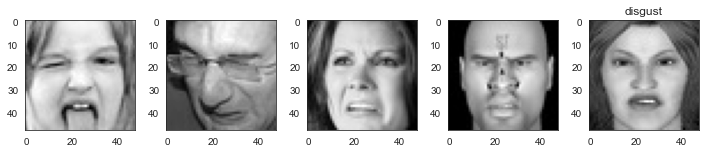

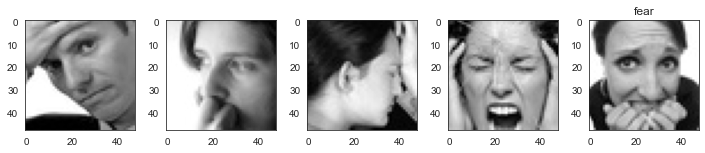

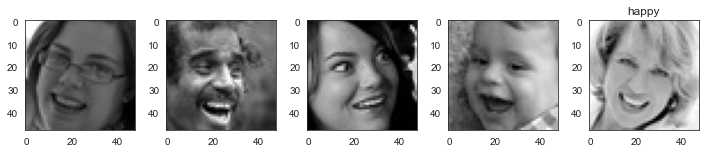

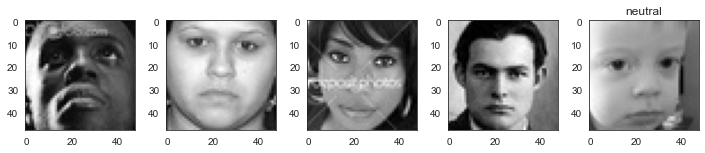

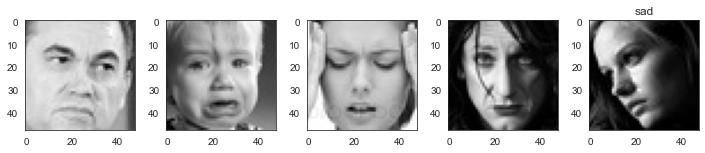

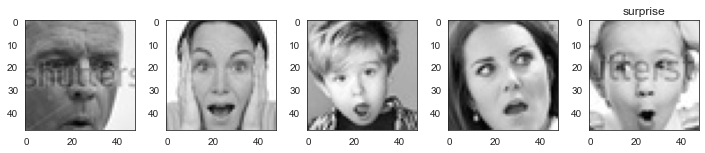

In [796]:
#plotting images for each class
for emotion in emotions: 
    plot_images(os.path.join(train_dir, emotion))
    plt.title(emotion)


# **DATA PROCESSING**

DATA AUGMENTATION

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.
You can apply any random transformations on each training image as it is passed to the model. This will not only make your model robust but will also save up on the overhead memory.
ImageDataGenerator class ensures that the model receives new variations of the images at each epoch.

In [11]:
#Defining the augmentation parameters

'''
rotation_range:      rotates the image with the amount of degrees we provide
width_shift_range:   shifts the image randomly to the right or left along the width of the image
height_shift range:  shifts image randomly to up or down along the height of the image
horizontal_flip:     flips the image horizontally
rescale:             to scale down the pixel values in our image between 0 and 1
zoom_range:          applies random zoom to our object
brightness_range:    randomly changes the brightness of the image
'''


train_set = ImageDataGenerator(          rotation_range = 20,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         zoom_range = 0.1,
                                         brightness_range=[0.7,1.3] )

val_set = ImageDataGenerator( rescale = 1./255 )

test_set = ImageDataGenerator( rescale = 1./255 )

In [369]:
#applying augmentation on our datasets
''' 
target_size:   Size of the input image.
color_mode:    Set to rgb for 3 images with 3 channels and grayscalE 1 channel.
batch_size:    Size of each batch in which data will be passed.
class_mode:    Set to binary for only two label classification and categorical otherwise
'''

train_data = train_set.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 32,
                                                    color_mode ='rgb',
                                                    class_mode = "categorical"
                                                   )
val_data = test_set.flow_from_directory( directory = val_dir,
                                                              target_size = (48,48),
                                                              batch_size = 32,
                                                               color_mode ='rgb',
                                                              class_mode = "categorical"
                                                             )

test_data = test_set.flow_from_directory( directory = test_dir,
                                                              target_size = (48,48),
                                                              batch_size = 1,
                                                               color_mode ='rgb',
                                                              class_mode = "categorical"
                                                             )

Found 30528 images belonging to 7 classes.
Found 7232 images belonging to 7 classes.
Found 7 images belonging to 7 classes.


In [13]:
#CNN model definintion

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(5,5),padding = 'same',input_shape = (48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.35))
#dropout randomly switches off some neurons in the network which forces the data to find new paths,Therefore, this reduces overfitting.

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.35))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.35))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())

#1st Fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))


#2nd  Fully connected layer layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))

#Final prediction layer
model.add(Dense(7, activation='softmax'))


#MODEL COMPILATION
opt = Adam(learning_rate = 0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [14]:
# defining a callback that will save the best model
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# no. of epoch
epochs = 100

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0005),
              metrics=['accuracy'])

In [15]:
# Fitting and training the model
history = model.fit(train_data,
                        epochs=epochs,
                        validation_data = val_data,
                        callbacks=callbacks_list
                        ) 

Epoch 1/100
954/954 [==============================] - ETA: 0s - loss: 1.9748 - accuracy: 0.2187
Epoch 00001: val_accuracy improved from -inf to 0.25014, saving model to model.h5
954/954 [==============================] - 505s 528ms/step - loss: 1.9748 - accuracy: 0.2187 - val_loss: 1.8693 - val_accuracy: 0.2501
Epoch 2/100
954/954 [==============================] - ETA: 0s - loss: 1.7662 - accuracy: 0.2869
Epoch 00002: val_accuracy improved from 0.25014 to 0.30683, saving model to model.h5
954/954 [==============================] - 443s 464ms/step - loss: 1.7662 - accuracy: 0.2869 - val_loss: 1.8872 - val_accuracy: 0.3068
Epoch 3/100
954/954 [==============================] - ETA: 0s - loss: 1.6274 - accuracy: 0.3531
Epoch 00003: val_accuracy improved from 0.30683 to 0.31665, saving model to model.h5
954/954 [==============================] - 440s 462ms/step - loss: 1.6274 - accuracy: 0.3531 - val_loss: 1.6932 - val_accuracy: 0.3166
Epoch 4/100
954/954 [==============================]

954/954 [==============================] - ETA: 0s - loss: 1.1018 - accuracy: 0.5812
Epoch 00028: val_accuracy did not improve from 0.61684
954/954 [==============================] - 438s 459ms/step - loss: 1.1018 - accuracy: 0.5812 - val_loss: 1.0919 - val_accuracy: 0.5849
Epoch 29/100
954/954 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.5819
Epoch 00029: val_accuracy improved from 0.61684 to 0.62984, saving model to model.h5
954/954 [==============================] - 438s 459ms/step - loss: 1.1033 - accuracy: 0.5819 - val_loss: 0.9938 - val_accuracy: 0.6298
Epoch 30/100
954/954 [==============================] - ETA: 0s - loss: 1.0944 - accuracy: 0.5846
Epoch 00030: val_accuracy did not improve from 0.62984
954/954 [==============================] - 437s 458ms/step - loss: 1.0944 - accuracy: 0.5846 - val_loss: 1.1202 - val_accuracy: 0.5841
Epoch 31/100
954/954 [==============================] - ETA: 0s - loss: 1.0878 - accuracy: 0.5856
Epoch 00031: val_accu

954/954 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.6284
Epoch 00056: val_accuracy did not improve from 0.64712
954/954 [==============================] - 436s 457ms/step - loss: 0.9919 - accuracy: 0.6284 - val_loss: 1.0101 - val_accuracy: 0.6174
Epoch 57/100
954/954 [==============================] - ETA: 0s - loss: 0.9879 - accuracy: 0.6263
Epoch 00057: val_accuracy did not improve from 0.64712
954/954 [==============================] - 437s 459ms/step - loss: 0.9879 - accuracy: 0.6263 - val_loss: 0.9911 - val_accuracy: 0.6206
Epoch 58/100
954/954 [==============================] - ETA: 0s - loss: 0.9865 - accuracy: 0.6267
Epoch 00058: val_accuracy did not improve from 0.64712
954/954 [==============================] - 438s 459ms/step - loss: 0.9865 - accuracy: 0.6267 - val_loss: 1.0708 - val_accuracy: 0.5906
Epoch 59/100
954/954 [==============================] - ETA: 0s - loss: 0.9838 - accuracy: 0.6294
Epoch 00059: val_accuracy did not improve from 0.64

Epoch 84/100
954/954 [==============================] - ETA: 0s - loss: 0.9339 - accuracy: 0.6466
Epoch 00084: val_accuracy did not improve from 0.66842
954/954 [==============================] - 437s 458ms/step - loss: 0.9339 - accuracy: 0.6466 - val_loss: 0.9207 - val_accuracy: 0.6585
Epoch 85/100
954/954 [==============================] - ETA: 0s - loss: 0.9320 - accuracy: 0.6523
Epoch 00085: val_accuracy did not improve from 0.66842
954/954 [==============================] - 437s 458ms/step - loss: 0.9320 - accuracy: 0.6523 - val_loss: 0.9351 - val_accuracy: 0.6532
Epoch 86/100
954/954 [==============================] - ETA: 0s - loss: 0.9259 - accuracy: 0.6522
Epoch 00086: val_accuracy did not improve from 0.66842
954/954 [==============================] - 437s 458ms/step - loss: 0.9259 - accuracy: 0.6522 - val_loss: 0.9596 - val_accuracy: 0.6439
Epoch 87/100
954/954 [==============================] - ETA: 0s - loss: 0.9241 - accuracy: 0.6506
Epoch 00087: val_accuracy did not impr

In [16]:
#saving the best model
model.save("model.h5")

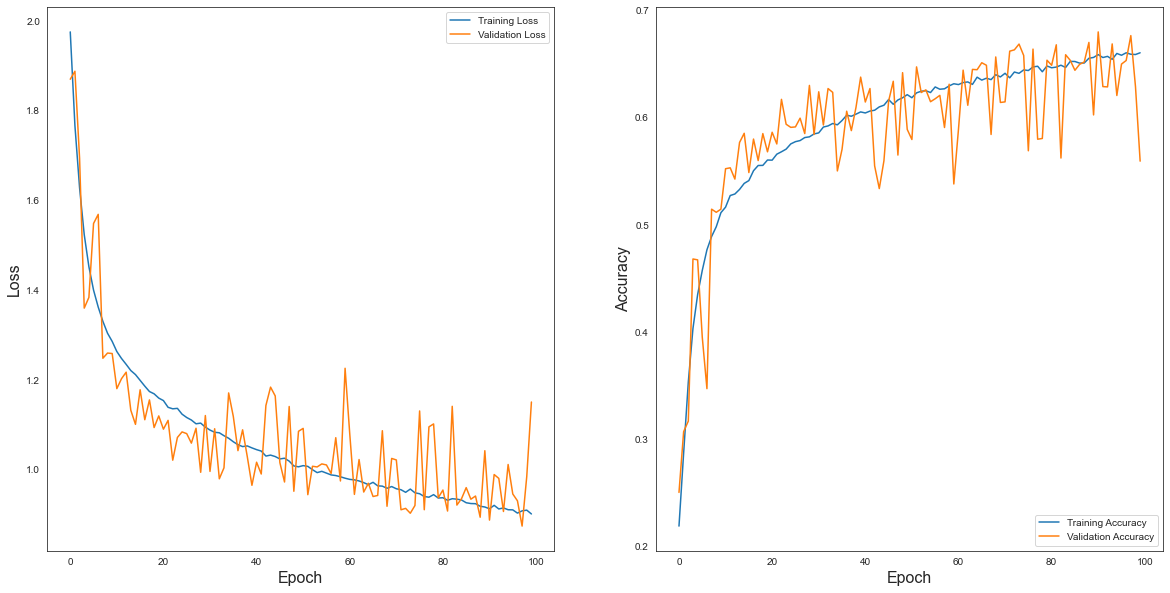

In [797]:
# plotting the Loss for training and validation set
sns.set_style("white")
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plotting the Accuracy for training and validation set
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
#MODEL ACCURACY
print(max(history.history['val_accuracy']))

0.6797566413879395


Our model have been trained, now we will use it to make predictions on our test data.
The test dataset consists of 1 photo for each emotion class.

In [757]:
#Prediction on test data
pred = model.predict(test_data)

#predicted emotion
predicted_class_indices=np.argmax(pred,axis=1)

#getting label of prediction
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#putting final result in a dataframe
result2 = pd.DataFrame({"Emotions":labels.values(),
                      "Predictions":predictions})

In [564]:
#print the predictions
results2

,Emotions,Predictions
0,angry,angry
1,disgust,surprise
2,fear,fear
3,happy,happy
4,neutral,neutral
5,sad,sad
6,surprise,angry


Wohoo!!!
5 out of 7 are correct. Our model is doing really well!!

# CONCLUSION
1. Our model has been trained with about 68% accuracy on validation set.
2. 5 out of 7 emotions have been predicted correctly on test set.